In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
COS–GASS ↔ TNG50 candidate matching with environment veto.

Adds a 300 kpc (physical) environment filter:
    - Reject a candidate subhalo if there exists ANY neighbor within 300 kpc
      (converted to ckpc/h via header a,h) whose stellar mass >= 20% of the
      candidate OR whose HI mass >= 20% of the candidate.

Other features:
    - Weighted 2-D matching in (log10 M_*, log10 M_HI) with robust scaling.
    - Proper periodic boundary handling (minimum-image convention).
    - Keeps your original inputs/outputs and logging style.
"""

import os, sys, json, math, logging, h5py
from datetime import datetime

import numpy as np
import pandas as pd

# tqdm that renders nicely in notebooks
try:
    from tqdm.auto import tqdm
    HAVE_TQDM = True
except Exception:
    HAVE_TQDM = False

import illustris_python as il  # make sure this is installed in your kernel

# ----------------------
# USER CONFIG (edit as needed)
# ----------------------
OBS_PATH   = "/home/tnguser/COSS_GASS/COS_GASS_parameters.txt"
HI_FILE    = "/home/tnguser/COSS_GASS/hih2_galaxy_099.hdf5"
SNAP       = 99

# Try these TNG basePaths in order; the first that exists will be used
TNG_BASEPATH_CANDIDATES = [
    "/home/tnguser/sims.TNG/TNG50-1/output",
    "/sims.TNG/TNG50-1/output",
    "sims.TNG/TNG50-1/output",
]

# HI model and type (dataset will be m_hi_{model}_{type})
HI_MODEL = "S14"   # choices: L08, GK11, K13, GD14, S14
HI_TYPE  = "vol"   # typical: "vol" (volumetric) or "map" (projected)

# Matching knobs
TOPK_BY_MSTAR      = 300   # shortlist size by M* before 2-D scoring
W_STAR, W_HI       = 1.0, 1.0   # weights in the 2-D distance
USE_ROBUST_SCALING = True       # if True, scale each axis by a robust sigma
REQUIRE_FINITE_HI  = True       # if True, drop sim candidates with non-finite HI when obs has HI

# --- Environment veto config ---
PHYS_RADIUS_KPC       = 300.0   # physical radius for neighbor search
MASS_RATIO_THRESHOLD  = 0.20    # 20% in M* or M_HI

# Outputs
OUT_TXT = "/home/tnguser/COSS_GASS/COS_GASS_TNG50_matches.txt"
OUT_CSV = "/home/tnguser/COSS_GASS/COS_GASS_TNG50_matches_index.csv"

# ----------------------
# Logging (reset handlers so we don't double-log in Jupyter)
# ----------------------
for h in list(logging.root.handlers):
    logging.root.removeHandler(h)
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# ----------------------
# Small utils
# ----------------------
def log10_safe(x):
    x = np.asarray(x)
    with np.errstate(divide="ignore", invalid="ignore"):
        return np.log10(x)

def find_existing_basepath(candidates):
    for p in candidates:
        if os.path.isdir(p):
            logging.info(f"Using TNG basePath: {p}")
            return p
        else:
            logging.debug(f"Checked basePath (not found): {p}")
    raise FileNotFoundError("Could not locate TNG50-1 'output' directory among: " + ", ".join(candidates))

def read_obs_table(path):
    logging.info(f"Reading observed table: {path}")
    df = pd.read_csv(path, sep=",", engine="python", skip_blank_lines=True)
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]
    df = df.applymap(lambda x: np.nan if (isinstance(x, str) and x.strip() == "-") else x)

    float_cols = ["M_star", "M_HI", "R_HI", "R_vir", "rho", "phi", "inc"]
    for c in float_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df["COS_ID"] = pd.to_numeric(df["COS_ID"], errors="coerce").astype(pd.Int64Dtype())
    df["Galaxy"] = df["Galaxy"].astype(str).str.strip()

    logging.info(f"Observed table shape: {df.shape}")
    logging.debug(f"Observed NaN counts:\n{df.isna().sum()}")
    return df

def get_hubble_param(basePath, snap):
    hdr = il.groupcat.loadHeader(basePath, snap)
    h = float(hdr["HubbleParam"])
    logging.info(f"HubbleParam={h}  (snap={snap})")
    return h, hdr

def load_subhalo_basics(basePath, snap):
    """
    Return:
        flags:        (N,) int16
        mstar_1e10h:  (N,) float64   stellar mass in 1e10 Msun/h
        grnr:         (N,) int64
        pos_ckpch:    (N,3) float64  positions in ckpc/h
    """
    fields = ["SubhaloFlag", "SubhaloMassType", "SubhaloGrNr", "SubhaloPos"]
    logging.info("Loading subhalo scalar arrays from group catalogs...")
    sub = il.groupcat.loadSubhalos(basePath, snap, fields=fields)

    flags = np.array(sub["SubhaloFlag"], dtype=np.int16)
    mass_type = np.array(sub["SubhaloMassType"], dtype=np.float64)  # (N,6)
    grnr = np.array(sub["SubhaloGrNr"], dtype=np.int64)
    pos_ckpch = np.array(sub["SubhaloPos"], dtype=np.float64)       # (N,3) in ckpc/h

    if mass_type.ndim != 2 or mass_type.shape[1] < 5:
        raise RuntimeError("Unexpected SubhaloMassType shape; expected (N, >=5).")

    nsub = flags.size
    logging.info(f"Nsubhalos = {nsub}")
    return flags, mass_type[:, 4].copy(), grnr, pos_ckpch  # stellar component + positions

def _try_dataset(f: h5py.File, name: str):
    if name in f:
        return f[name][...]
    if "Subhalo" in f and name in f["Subhalo"]:
        return f["Subhalo"][name][...]
    if "galaxy" in f and name in f["galaxy"]:
        return f["galaxy"][name][...]
    raise KeyError(name)

def load_hi_catalog_vector(hi_file, model="GK11", hi_type="vol", basePath=None, snap=None):
    ds_name = f"m_hi_{model}_{hi_type}"
    logging.info(f"Opening HI/H2 galaxy catalog: {hi_file}  (dataset={ds_name})")
    with h5py.File(hi_file, "r") as f:
        try:
            id_sub = _try_dataset(f, "id_subhalo").astype(np.int64)
        except KeyError:
            id_sub = _try_dataset(f, "SubhaloID").astype(np.int64)
        try:
            id_grp = _try_dataset(f, "id_group").astype(np.int64)
        except Exception:
            id_grp = None

        try:
            m_hi = _try_dataset(f, ds_name).astype(np.float64)  # Msun
        except KeyError:
            available = []
            for k in f.keys():
                if k.startswith("m_hi_"):
                    available.append(k)
            if "Subhalo" in f:
                for k in f["Subhalo"].keys():
                    if k.startswith("m_hi_"):
                        available.append(k)
            raise KeyError(f"Dataset '{ds_name}' not found. Available: {sorted(set(available))}")

        meta = {"file": hi_file, "dataset": ds_name}
        if "config" in f:
            cfg = f["config"].attrs
            for k in ["sim", "snap_idx", "snap_z", "Mstar_min", "Mstar_max",
                      "Mgas_min", "Mgas_max", "profile_nbins"]:
                if k in cfg:
                    meta[k] = cfg[k]

    # Map into full subhalo index space if basePath/snap provided
    if basePath is not None and snap is not None:
        hdr = il.groupcat.loadHeader(basePath, snap)
        nsub_total = int(hdr["Nsubgroups_Total"])
        hi_log = np.full(nsub_total, np.nan, dtype=np.float64)
        with np.errstate(divide="ignore", invalid="ignore"):
            hi_log_compact = np.log10(m_hi)
        valid = (id_sub >= 0) & (id_sub < nsub_total)
        hi_log[id_sub[valid]] = hi_log_compact[valid]
        logging.info(f"HI catalog galaxies in file: {id_sub.size}; mapped into Nsub={nsub_total}")
        if (~valid).any():
            logging.warning(f"{np.sum(~valid)} entries had out-of-range Subhalo IDs; ignored.")
        return hi_log, id_sub, id_grp, meta

    with np.errstate(divide="ignore", invalid="ignore"):
        hi_log_compact = np.log10(m_hi)
    return hi_log_compact, id_sub, id_grp, meta

def match_candidates_weighted(
    row,
    logMstar_sub,
    valid_mask,
    hi_log=None,
    topk=300,
    w_star=1.0,
    w_hi=1.0,
    s_star=None,
    s_hi=None,
    require_finite_hi=True,
):
    """
    Weighted, simultaneous 2D minimization in (logM*, logMHI).

    Distance (if obs M_HI finite and hi_log available):
        dist^2 = w_star * (ΔlogM* / s_star)^2 + w_hi * (ΔlogMHI / s_hi)^2

    - If obs M_HI is NaN OR hi_log is None, falls back to M* only.
    - If require_finite_hi=True and obs has M_HI, candidates without finite HI are dropped.
      If that leaves zero candidates, falls back to M* only.

    Returns: list of (subID, absΔlogM*, absΔlogMHI, dist)
    """
    target_logMstar = float(row["M_star"])
    dMstar_all = np.abs(logMstar_sub - target_logMstar)
    dMstar_all[~valid_mask] = np.inf
    if not np.any(np.isfinite(dMstar_all)):
        return []

    # shortlist by stellar-mass proximity
    order = np.argsort(dMstar_all)
    cand = order[:min(topk, order.size)]

    # If no HI info to use, return top-15 by M*
    use_hi = (hi_log is not None) and np.isfinite(row.get("M_HI", np.nan))
    if not use_hi:
        top = cand[:15]
        return [(int(sid), float(dMstar_all[sid]), np.nan, float(dMstar_all[sid])) for sid in top]

    # Optionally require finite HI for candidates
    if require_finite_hi:
        finite_hi_mask = np.isfinite(hi_log[cand])
        cand = cand[finite_hi_mask]
        if cand.size == 0:
            top = order[:15]
            return [(int(sid), float(dMstar_all[sid]), np.nan, float(dMstar_all[sid])) for sid in top]

    target_logMHI = float(row["M_HI"])
    dStar = (logMstar_sub[cand] - target_logMstar)  # signed
    dHI   = (hi_log[cand]        - target_logMHI)   # signed

    # optional scale normalizations (robust sigmas); if None, no scaling
    ds = dStar / s_star if (s_star is not None and s_star > 0) else dStar
    dh = dHI   / s_hi   if (s_hi   is not None and s_hi   > 0) else dHI

    dist2 = (w_star * ds**2) + (w_hi * dh**2)
    ord2 = np.argsort(dist2)
    top = cand[ord2[:15]]

    out = []
    for sid in top:
        abs_dms = abs(float(logMstar_sub[sid] - target_logMstar))
        abs_dhi = abs(float(hi_log[sid] - target_logMHI)) if (hi_log is not None and np.isfinite(hi_log[sid])) else np.nan
        ds_ = float(logMstar_sub[sid] - target_logMstar)
        dh_ = float(hi_log[sid] - target_logMHI) if (hi_log is not None and np.isfinite(hi_log[sid])) else 0.0
        ds_scaled = (ds_ / s_star) if (s_star is not None and s_star > 0) else ds_
        dh_scaled = (dh_ / s_hi)   if (s_hi   is not None and s_hi   > 0) else dh_
        dist_val = math.sqrt(w_star * ds_scaled**2 + w_hi * dh_scaled**2)
        out.append((int(sid), abs_dms, abs_dhi, dist_val))
    return out

def dump_dict(d, prefix=""):
    lines = []
    for k in sorted(d.keys()):
        v = d[k]
        if isinstance(v, (list, tuple, np.ndarray)):
            try: v = np.array(v).tolist()
            except Exception: v = str(v)
        lines.append(f"{prefix}{k}: {v}")
    return "\n".join(lines)

def sanity_check_units_and_ranges(logMstar_sub, hi_log, obs_df):
    logging.info("Sanity ranges:")
    logging.info(f"  Sim logM*  : min={np.nanmin(logMstar_sub):.3f}, max={np.nanmax(logMstar_sub):.3f}")
    if hi_log is not None:
        logging.info(f"  Sim logMHI : min={np.nanmin(hi_log):.3f}, max={np.nanmax(hi_log):.3f}, NaNs={np.sum(~np.isfinite(hi_log))}")
    logging.info(f"  Obs logM*  : min={np.nanmin(obs_df['M_star']):.3f}, max={np.nanmax(obs_df['M_star']):.3f}")
    if "M_HI" in obs_df:
        logging.info(f"  Obs logMHI : min={np.nanmin(obs_df['M_HI']):.3f}, max={np.nanmax(obs_df['M_HI']):.3f}, NaNs={(~np.isfinite(obs_df['M_HI'])).sum()}")

def robust_sigma(x):
    x = np.asarray(x, float)
    med = np.nanmedian(x)
    return 1.4826 * np.nanmedian(np.abs(x - med))

# ----------------------
# Environment veto helpers
# ----------------------
def _min_image_sqdist(p_ref, P_all, Lbox):
    """
    Minimum-image squared distances from p_ref to all positions in P_all.
    All in ckpc/h. p_ref shape (3,), P_all shape (N,3).
    """
    d = np.abs(P_all - p_ref)
    d = np.minimum(d, Lbox - d)
    return np.sum(d * d, axis=1)

def has_disqualifying_neighbor(
    sid,
    sub_pos, logMstar_sub, hi_log,
    valid_mask, R2_env, Lbox,
    mass_ratio_thresh=0.20
):
    """
    True if there exists any neighbor within the environment radius that has
    M* >= mass_ratio_thresh * M*_candidate  OR
    M_HI >= mass_ratio_thresh * M_HI_candidate.
    """
    # Candidate position and masses
    p = sub_pos[sid]  # ckpc/h

    # Candidate stellar mass must be finite to compare neighbors by M*
    if not np.isfinite(logMstar_sub[sid]):
        return False  # don't veto by environment if no M*

    Mstar_cand = 10.0 ** logMstar_sub[sid]  # Msun

    # HI of candidate (may be NaN)
    MHI_cand = None
    if (hi_log is not None) and np.isfinite(hi_log[sid]):
        MHI_cand = 10.0 ** hi_log[sid]      # Msun

    # Distances to all valid neighbors (flag==1, positive mass), excluding self
    vm = valid_mask.copy()
    vm[sid] = False

    # Fast prefilter: only consider valid neighbors
    dist2 = _min_image_sqdist(p, sub_pos[vm], Lbox)
    within = dist2 <= R2_env
    if not np.any(within):
        return False

    # Neighbor indices in the full catalog
    nbr_idx_all = np.nonzero(vm)[0]
    nbrs = nbr_idx_all[within]

    # Stellar mass condition
    cond_star = np.zeros(nbrs.size, dtype=bool)
    ms_good = np.isfinite(logMstar_sub[nbrs])
    if np.any(ms_good):
        Mstar_nbr = np.zeros(nbrs.size, dtype=np.float64)
        Mstar_nbr[ms_good] = 10.0 ** logMstar_sub[nbrs[ms_good]]
        cond_star[ms_good] = (Mstar_nbr[ms_good] >= mass_ratio_thresh * Mstar_cand)

    # HI mass condition (only if candidate HI is finite)
    if (hi_log is not None) and (MHI_cand is not None):
        cond_hi = np.zeros(nbrs.size, dtype=bool)
        hi_good = np.isfinite(hi_log[nbrs])
        if np.any(hi_good):
            MHI_nbr = np.zeros(nbrs.size, dtype=np.float64)
            MHI_nbr[hi_good] = 10.0 ** hi_log[nbrs[hi_good]]
            cond_hi[hi_good] = (MHI_nbr[hi_good] >= mass_ratio_thresh * MHI_cand)
    else:
        cond_hi = np.zeros(nbrs.size, dtype=bool)

    return bool(np.any(cond_star | cond_hi))



2025-10-04 04:51:45,577 [INFO] Using TNG basePath: /home/tnguser/sims.TNG/TNG50-1/output
2025-10-04 04:51:45,579 [INFO] Reading observed table: /home/tnguser/COSS_GASS/COS_GASS_parameters.txt
/tmp/ipykernel_9033/2670867817.py:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.nan if (isinstance(x, str) and x.strip() == "-") else x)
2025-10-04 04:51:45,737 [INFO] Observed table shape: (18, 9)
2025-10-04 04:51:45,908 [INFO] HubbleParam=0.6774  (snap=99)
2025-10-04 04:51:45,910 [INFO] Loading subhalo scalar arrays from group catalogs...
2025-10-04 04:57:42,170 [INFO] Nsubhalos = 5688113
2025-10-04 04:57:57,277 [INFO] Opening HI/H2 galaxy catalog: /home/tnguser/COSS_GASS/hih2_galaxy_099.hdf5  (dataset=m_hi_S14_vol)
2025-10-04 04:58:09,193 [INFO] HI catalog galaxies in file: 39259; mapped into Nsub=5688113
2025-10-04 04:58:09,196 [INFO] HI dataset used: m_hi_S14_vol from hih2_galaxy_099.hdf5
2025-10-04 04:58:09,197 [INFO] Sa

Matching (2-D weighted + env veto):   0%|          | 0/18 [00:00<?, ?it/s]

2025-10-04 05:05:40,528 [INFO] [OK] Wrote report: /home/tnguser/COSS_GASS/COS_GASS_TNG50_matches.txt
2025-10-04 05:05:40,530 [INFO] [OK] Wrote match index: /home/tnguser/COSS_GASS/COS_GASS_TNG50_matches_index.csv


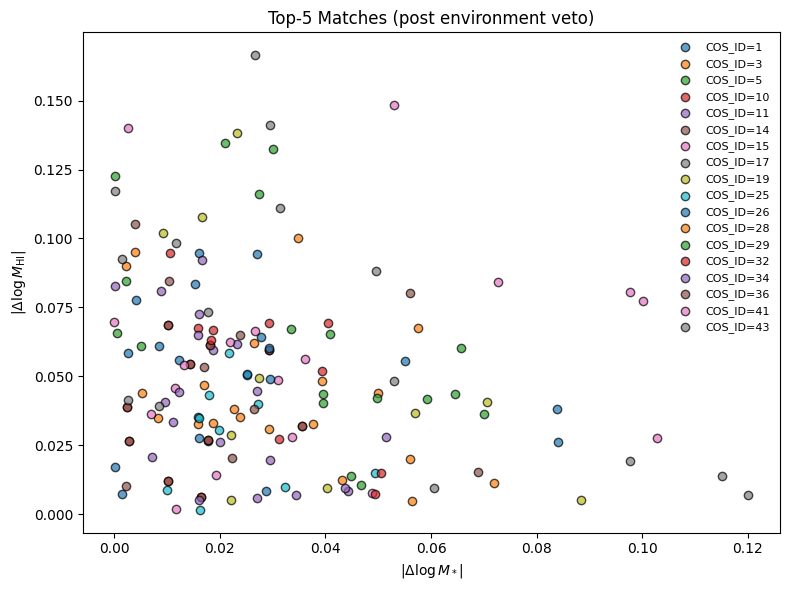

In [2]:
# ----------------------
# MAIN PIPELINE
# ----------------------
def main():
    basePath = find_existing_basepath(TNG_BASEPATH_CANDIDATES)
    os.makedirs(os.path.dirname(OUT_TXT), exist_ok=True)

    # 1) Observed table
    obs = read_obs_table(OBS_PATH)

    # 2) Group catalog header + essentials
    h, hdr = get_hubble_param(basePath, SNAP)
    a = float(hdr["Time"])      # scale factor
    Lbox = float(hdr["BoxSize"])  # ckpc/h
    flags, mstar_1e10h, sub_grnr, sub_pos = load_subhalo_basics(basePath, SNAP)
    nsub = mstar_1e10h.size

    # Valid subhalos for matching/neighbors
    valid_mask = (flags == 1) & np.isfinite(mstar_1e10h) & (mstar_1e10h > 0)

    # Stellar mass in Msun (log10)
    logMstar_sub = np.full(nsub, np.nan, dtype=np.float64)
    logMstar_sub[valid_mask] = log10_safe(mstar_1e10h[valid_mask] * (1e10 / h))

    # 3) Atomic HI from your galaxy file (mapped into full subhalo space)
    hi_log, id_sub, id_grp, hi_meta = load_hi_catalog_vector(
        HI_FILE, model=HI_MODEL, hi_type=HI_TYPE, basePath=basePath, snap=SNAP
    )
    logging.info(f"HI dataset used: {hi_meta['dataset']} from {os.path.basename(hi_meta['file'])}")

    # 4) Optional sanity checks
    sanity_check_units_and_ranges(logMstar_sub, hi_log, obs)

    # 5) Robust scale factors (so both axes contribute comparably)
    if USE_ROBUST_SCALING:
        s_star = robust_sigma(logMstar_sub[np.isfinite(logMstar_sub)])
        s_hi   = robust_sigma(hi_log[np.isfinite(hi_log)])
    else:
        s_star = None
        s_hi   = None
    logging.info(f"Scales: s_star={s_star if s_star is not None else 'None'}, s_hi={s_hi if s_hi is not None else 'None'}")

    # 6) Environment radius in ckpc/h (physical → comoving/h)
    R_env_ckpch = PHYS_RADIUS_KPC * h / a   #  r_ckpc/h = r_phys_kpc * h / a
    R2_env = R_env_ckpch * R_env_ckpch
    logging.info(f"Environment veto: radius = {PHYS_RADIUS_KPC:.1f} kpc physical -> {R_env_ckpch:.2f} ckpc/h (a={a:.3f}, h={h:.3f})")
    logging.info(f"Mass-ratio threshold: {MASS_RATIO_THRESHOLD:.2f} (>=20% rule)")

    # 7) Prepare report header
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    header_lines = [
        "# COS-GASS ↔ TNG50-1 matches (snap=99, z≈0)",
        f"# Generated: {now}",
        f"# TNG basePath: {basePath}",
        "# Matching: weighted 2-D distance in (log10 M_*, log10 M_HI).",
        f"# Weights: W_STAR={W_STAR}, W_HI={W_HI} ; Scales: s_star={'None' if s_star is None else f'{s_star:.3f}'} dex, s_hi={'None' if s_hi is None else f'{s_hi:.3f}'} dex",
        f"# HI file: {hi_meta['file']}",
        f"# HI dataset: {hi_meta['dataset']}  (Msun; log10 used for matching)",
        f"# Environment veto: radius={PHYS_RADIUS_KPC} kpc physical  ->  {R_env_ckpch:.2f} ckpc/h ; ratio≥{MASS_RATIO_THRESHOLD:.2f} in M* or M_HI",
        "# Observed columns: COS_ID, Galaxy, M_star, M_HI, R_HI[kpc], R_vir[kpc], rho[kpc], phi[deg], inc[deg]",
        "# CSV columns: COS_ID, Galaxy, MatchRank, SubhaloID, GroupID, dlogMstar, dlogMHI, dist",
        "# Block layout:",
        "#   Obs Gal <COS_ID> information",
        "#   ******************** SIm Data Gal <COS_ID> filter *************************",
        "#   Match 1..5: full Subhalo.* and Group.* dump (post environment veto)",
        "# ------------------------------------------------------------",
        ""
    ]

    # 8) Matching + write outputs
    csv_rows = []
    iter_rows = obs.itertuples(index=False)
    if HAVE_TQDM:
        iter_rows = tqdm(iter_rows, total=len(obs), desc="Matching (2-D weighted + env veto)")

    with open(OUT_TXT, "w", encoding="utf-8") as fout:
        fout.write("\n".join(header_lines))

    for row in iter_rows:
        rowd = row._asdict()

        matches = match_candidates_weighted(
            rowd, logMstar_sub, valid_mask,
            hi_log=hi_log, topk=TOPK_BY_MSTAR,
            w_star=W_STAR, w_hi=W_HI,
            s_star=s_star, s_hi=s_hi,
            require_finite_hi=REQUIRE_FINITE_HI
        )

        # Observed block header
        with open(OUT_TXT, "a", encoding="utf-8") as fout:
            fout.write(f"Obs Gal {int(rowd['COS_ID'])} information\n")
            fout.write(f"COS_ID: {int(rowd['COS_ID'])}\n")
            fout.write(f"Galaxy: {rowd['Galaxy']}\n")
            fout.write(f"M_star_log10: {rowd['M_star']}\n")
            fout.write(f"M_HI_log10: {rowd.get('M_HI', np.nan)}\n")
            fout.write(f"R_HI_kpc: {rowd.get('R_HI', np.nan)}\n")
            fout.write(f"R_vir_kpc: {rowd.get('R_vir', np.nan)}\n")
            fout.write(f"rho_kpc: {rowd.get('rho', np.nan)}\n")
            fout.write(f"phi_deg: {rowd.get('phi', np.nan)}\n")
            fout.write(f"inc_deg: {rowd.get('inc', np.nan)}\n")
            fout.write("******************** SIm Data Gal {} filter *************************\n".format(int(rowd['COS_ID'])))

        if not matches:
            logging.warning(f"No matches (pre-env) for COS_ID={rowd['COS_ID']}")
            with open(OUT_TXT, "a", encoding="utf-8") as fout:
                fout.write("No valid simulated matches found (check flags/mass ranges).\n\n")
            continue

        # --- NEW: environment veto (300 kpc physical, ≥20% in M* or HI) ---
        filtered = []
        for sid, dms, dhi, dist_val in matches:
            try:
                veto = has_disqualifying_neighbor(
                    sid,
                    sub_pos=sub_pos,
                    logMstar_sub=logMstar_sub,
                    hi_log=hi_log,
                    valid_mask=valid_mask,
                    R2_env=R2_env,
                    Lbox=Lbox,
                    mass_ratio_thresh=MASS_RATIO_THRESHOLD
                )
            except Exception as e:
                logging.warning(f"Env check failed for SubhaloID={sid}: {e}")
                veto = False  # fail-open to not accidentally drop good candidates
            if not veto:
                filtered.append((sid, dms, dhi, dist_val))

        # Keep only the top 5 after veto
        matches_post = filtered[:10]

        if not matches_post:
            logging.info(f"COS_ID={rowd['COS_ID']}: all {len(matches)} prelim matches vetoed by environment.")
            with open(OUT_TXT, "a", encoding="utf-8") as fout:
                fout.write("All prelim matches vetoed by environment.\n\n")
            continue

        for rank, (sid, dms, dhi, dist_val) in enumerate(matches_post, 1):
            # Full dumps
            sub_all = il.groupcat.loadSingle(basePath, SNAP, subhaloID=int(sid))
            gid = int(sub_all["SubhaloGrNr"])
            grp_all = il.groupcat.loadSingle(basePath, SNAP, haloID=gid)

            with open(OUT_TXT, "a", encoding="utf-8") as fout:
                fout.write(
                    f"Match {rank}: SubhaloID={sid}, GroupID={gid}, "
                    f"dlogMstar={dms:.4f}, dlogMHI={dhi if np.isfinite(dhi) else np.nan}, "
                    f"dist={dist_val:.4f}\n"
                )
                fout.write("[Subhalo fields]\n")
                fout.write(dump_dict(sub_all, prefix="Subhalo."))
                fout.write("\n[Group fields]\n")
                fout.write(dump_dict(grp_all, prefix="Group."))
                fout.write("\n---\n")

            csv_rows.append(dict(
                COS_ID=int(rowd["COS_ID"]),
                Galaxy=rowd["Galaxy"],
                MatchRank=rank,
                SubhaloID=sid,
                GroupID=gid,
                dlogMstar=dms,
                dlogMHI=(float(dhi) if np.isfinite(dhi) else np.nan),
                dist=dist_val
            ))

        with open(OUT_TXT, "a", encoding="utf-8") as fout:
            fout.write("\n")

    # Save the quick index CSV and preview
    pd.DataFrame(csv_rows).to_csv(OUT_CSV, index=False)
    logging.info(f"[OK] Wrote report: {OUT_TXT}")
    logging.info(f"[OK] Wrote match index: {OUT_CSV}")

    # Optional quick peek (guard for non-notebook)
    try:
        import matplotlib.pyplot as plt
        idx = pd.read_csv(OUT_CSV)
        plt.figure(figsize=(8, 6))
        for cos_id in idx["COS_ID"].unique():
            sel = idx[idx["COS_ID"] == cos_id]
            plt.scatter(
                sel["dlogMstar"],
                sel["dlogMHI"],
                label=f"COS_ID={cos_id}",
                alpha=0.7,
                edgecolor='k',
            )
        plt.xlabel(r"$|\Delta \log M_*|$")
        plt.ylabel(r"$|\Delta \log M_{\rm HI}|$")
        plt.title("Top-5 Matches (post environment veto)")
        plt.legend(frameon=False, fontsize=8, loc="best")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.info(f"Plot preview skipped: {e}")

if __name__ == "__main__":
    main()

INFO: Using TNG basePath: /home/tnguser/sims.TNG/TNG50-1/output
INFO: Loaded logM* for 161920 valid subhalos out of 5688113.
INFO: HI: mapped 39259 / 39259 entries into Nsub=5688113 (dataset=m_hi_S14_vol, file=hih2_galaxy_099.hdf5)
INFO: [OK] Wrote cosgass_offsets.csv with 72 candidate rows (18 galaxies).


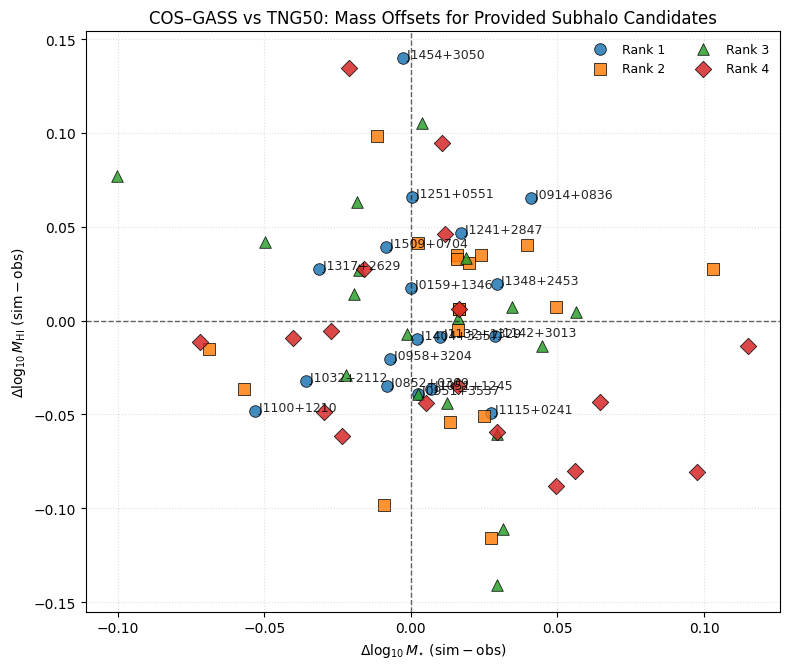

INFO: Finite offsets (both axes): 72 / 72 candidates (18 galaxies plotted).
INFO: Both masses available (sim+obs): 72 / 72 candidates.


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
COS–GASS 2D offset check (log M* , log M_HI) for provided SubhaloIDs.

Inputs:
  - COS_GASS_TNG.txt : CSV with columns
      COS_ID, Galaxy, M_star, M_HI, R_HI, R_vir, rho, phi, inc,
      SubhaloID1, SubhaloID2, SubhaloID3, SubhaloID4  (IDs at snap=99)
  - TNG50-1/output   : for group catalogs (SubhaloMassType for stellar masses)
  - HI catalog (hih2_galaxy_099.hdf5, etc.) with dataset m_hi_{MODEL}_{TYPE}

Outputs:
  - cosgass_offsets.csv : per candidate (4 per galaxy) ΔlogM*, ΔlogMHI with flags
  - cosgass_offsets.png/pdf : 2D scatter of offsets, color/marker by rank (1..4)
"""

import os, math, logging, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import illustris_python as il  # pip install illustris_python

# ───────────────────────────
# USER CONFIG
# ───────────────────────────
IN_FILE   = "COS_GASS_TNG.txt"     # your sample file
SNAP      = 99
HI_FILE   = "hih2_galaxy_099.hdf5"
HI_MODEL  = "S14"                   # e.g., L08, GK11, K13, GD14, S14
HI_TYPE   = "vol"                   # e.g., "vol" or "map"

TNG_BASEPATH_CANDIDATES = [
    "/home/tnguser/sims.TNG/TNG50-1/output",
    "/sims.TNG/TNG50-1/output",
    "sims.TNG/TNG50-1/output",
]

OUT_CSV = "cosgass_offsets.csv"
OUT_PNG = "cosgass_offsets.png"
OUT_PDF = "cosgass_offsets.pdf"

# Plot aesthetics
MARKERS = {1: "o", 2: "s", 3: "^", 4: "D"}   # rank -> marker
ALPHA   = 0.85
SIZE    = 70

# ───────────────────────────
# Logging
# ───────────────────────────
for h in list(logging.root.handlers):
    logging.root.removeHandler(h)
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")


# ───────────────────────────
# Helpers
# ───────────────────────────
def find_existing_basepath(candidates):
    for p in candidates:
        if os.path.isdir(p):
            logging.info(f"Using TNG basePath: {p}")
            return p
    raise FileNotFoundError("Could not locate TNG50-1 'output' directory among: " + ", ".join(candidates))

def log10_safe(x):
    x = np.asarray(x, float)
    with np.errstate(divide="ignore", invalid="ignore"):
        return np.log10(x)

def _try_dataset(f: h5py.File, name: str):
    if name in f:
        return f[name][...]
    if "Subhalo" in f and name in f["Subhalo"]:
        return f["Subhalo"][name][...]
    if "galaxy" in f and name in f["galaxy"]:
        return f["galaxy"][name][...]
    raise KeyError(name)

def load_hi_vector_mapped(hi_file, model, hi_type, basePath, snap):
    """
    Returns:
        hi_log_full : (Nsub_total,) log10(M_HI/Msun) with NaN where unavailable
    """
    ds_name = f"m_hi_{model}_{hi_type}"
    with h5py.File(hi_file, "r") as f:
        try:
            id_sub = _try_dataset(f, "id_subhalo").astype(np.int64)
        except KeyError:
            id_sub = _try_dataset(f, "SubhaloID").astype(np.int64)
        mhi = _try_dataset(f, ds_name).astype(np.float64)  # Msun
        hi_log_compact = log10_safe(mhi)

    hdr = il.groupcat.loadHeader(basePath, snap)
    nsub_total = int(hdr["Nsubgroups_Total"])
    hi_log_full = np.full(nsub_total, np.nan, dtype=np.float64)

    valid = (id_sub >= 0) & (id_sub < nsub_total)
    hi_log_full[id_sub[valid]] = hi_log_compact[valid]

    logging.info(f"HI: mapped {np.sum(valid)} / {id_sub.size} entries into Nsub={nsub_total} "
                 f"(dataset={ds_name}, file={os.path.basename(hi_file)})")
    return hi_log_full

def load_subhalo_logMstar(basePath, snap):
    """
    Returns:
        logMstar : (Nsub,) log10(Mstar/Msun) with NaN where invalid
    """
    sub = il.groupcat.loadSubhalos(basePath, snap, fields=["SubhaloFlag", "SubhaloMassType"])
    flags = np.array(sub["SubhaloFlag"], dtype=np.int16)
    mass_type = np.array(sub["SubhaloMassType"], dtype=np.float64)  # Msun/h in units of 1e10? -> illustris_python doc: Msun/h * 1e10
    if mass_type.ndim != 2 or mass_type.shape[1] < 5:
        raise RuntimeError("Unexpected SubhaloMassType shape; expected (N, >=5).")
    # Stellar mass component index = 4; units are 1e10 Msun/h
    hdr = il.groupcat.loadHeader(basePath, snap)
    h = float(hdr["HubbleParam"])
    mstar_1e10h = mass_type[:, 4]
    good = (flags == 1) & np.isfinite(mstar_1e10h) & (mstar_1e10h > 0)
    logMstar = np.full(mstar_1e10h.size, np.nan, dtype=np.float64)
    # convert to Msun: (1e10 Msun/h) * 1e10 / h
    logMstar[good] = log10_safe(mstar_1e10h[good] * (1e10 / h))
    logging.info(f"Loaded logM* for {np.sum(good)} valid subhalos out of {mstar_1e10h.size}.")
    return logMstar

def safe_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def gather_candidate_offsets(row, logMstar_sub, hi_log_sub):
    """
    For the 4 candidate SubhaloIDs in the row, compute ΔlogM* and ΔlogMHI = (sim - obs).
    Returns a list of dicts (one per candidate with rank 1..4).
    """
    out = []
    obs_Ms = safe_float(row["M_star"])
    obs_Mh = safe_float(row["M_HI"])  # can be NaN

    for rank, key in enumerate(["SubhaloID1", "SubhaloID2", "SubhaloID3", "SubhaloID4"], start=1):
        sid = row.get(key, None)
        try:
            sid = int(sid)
        except Exception:
            sid = None

        rec = dict(
            COS_ID=int(row["COS_ID"]),
            Galaxy=str(row["Galaxy"]),
            Rank=rank,
            SubhaloID=(int(sid) if sid is not None else -1),
            M_star_obs=obs_Ms,
            M_HI_obs=obs_Mh,
            logMstar_sim=np.nan,
            logMHI_sim=np.nan,
            dlogMstar=np.nan,
            dlogMHI=np.nan,
            have_Mstar_sim=False,
            have_MHI_sim=False
        )

        if sid is None or sid < 0 or sid >= logMstar_sub.size:
            out.append(rec); continue

        # sim stellar
        ms_sim = logMstar_sub[sid]
        if np.isfinite(ms_sim):
            rec["logMstar_sim"] = ms_sim
            rec["have_Mstar_sim"] = True
            if np.isfinite(obs_Ms):
                rec["dlogMstar"] = ms_sim - obs_Ms

        # sim HI
        if hi_log_sub is not None and sid < hi_log_sub.size:
            mh_sim = hi_log_sub[sid]
            if np.isfinite(mh_sim):
                rec["logMHI_sim"] = mh_sim
                rec["have_MHI_sim"] = True
                if np.isfinite(obs_Mh):
                    rec["dlogMHI"] = mh_sim - obs_Mh

        out.append(rec)
    return out


# ───────────────────────────
# MAIN
# ───────────────────────────
def main():
    basePath = find_existing_basepath(TNG_BASEPATH_CANDIDATES)

    # Read input table
    df = pd.read_csv(IN_FILE)
    # Normalize headers (just in case)
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]

    # Load simulation mass vectors
    logMstar_sub = load_subhalo_logMstar(basePath, SNAP)
    hi_log_sub   = load_hi_vector_mapped(HI_FILE, HI_MODEL, HI_TYPE, basePath, SNAP)

    # Build per-candidate offsets
    rows = []
    for rec in df.to_dict(orient="records"):
        rows.extend(gather_candidate_offsets(rec, logMstar_sub, hi_log_sub))

    offsets = pd.DataFrame(rows)
    # Quick sanity flags
    offsets["OK_both"] = offsets["have_Mstar_sim"] & offsets["have_MHI_sim"] & \
                         np.isfinite(offsets["M_star_obs"]) & np.isfinite(offsets["M_HI_obs"])
    offsets.to_csv(OUT_CSV, index=False)
    logging.info(f"[OK] Wrote {OUT_CSV} with {len(offsets)} candidate rows "
                 f"({offsets['COS_ID'].nunique()} galaxies).")

    # ── Plot ΔlogM* vs ΔlogMHI (one point per candidate; NaNs dropped on either axis)
    plot_df = offsets[np.isfinite(offsets["dlogMstar"]) & np.isfinite(offsets["dlogMHI"])].copy()
    if plot_df.empty:
        logging.warning("No finite (dlogM*, dlogMHI) pairs to plot. Check HI dataset/model/type and input masses.")
        return

    plt.figure(figsize=(8.0, 6.8))
    # Style by rank (1..4)
    for rank in sorted(plot_df["Rank"].unique()):
        sel = plot_df[plot_df["Rank"] == rank]
        if sel.empty: continue
        plt.scatter(
            sel["dlogMstar"], sel["dlogMHI"],
            s=SIZE, alpha=ALPHA, marker=MARKERS.get(rank, "o"),
            edgecolor="k", linewidths=0.6, label=f"Rank {rank}"
        )

    # Add a subtle cross-hair at (0,0)
    plt.axhline(0, ls="--", lw=1.0, alpha=0.6, color="k")
    plt.axvline(0, ls="--", lw=1.0, alpha=0.6, color="k")

    # Light annotations: one per galaxy near its rank-1 point
    try:
        # prefer rank-1 for labels to reduce clutter
        lab = (plot_df.sort_values(["COS_ID","Rank"])
                      .drop_duplicates(subset=["COS_ID"], keep="first"))
        for _, r in lab.iterrows():
            plt.text(r["dlogMstar"], r["dlogMHI"], f" {r['Galaxy']}",
                     fontsize=9, alpha=0.85)
    except Exception:
        pass

    plt.xlabel(r"$\Delta \log_{10} M_{\star}\ \mathrm{(sim - obs)}$")
    plt.ylabel(r"$\Delta \log_{10} M_{\mathrm{HI}}\ \mathrm{(sim - obs)}$")
    plt.title("COS–GASS vs TNG50: Mass Offsets for Provided Subhalo Candidates")
    plt.grid(True, ls=":", alpha=0.4)
    plt.legend(frameon=False, ncols=2, fontsize=9)
    plt.tight_layout()
    plt.savefig(OUT_PNG, dpi=220)
    plt.savefig(OUT_PDF)
    plt.show()

    # Small summary
    n_both = int(offsets["OK_both"].sum())
    n_rows = len(offsets)
    logging.info(f"Finite offsets (both axes): {len(plot_df)} / {n_rows} candidates "
                 f"({plot_df['COS_ID'].nunique()} galaxies plotted).")
    logging.info(f"Both masses available (sim+obs): {n_both} / {n_rows} candidates.")

if __name__ == "__main__":
    main()